<a href="https://colab.research.google.com/github/paucaroscanoa/ApiBookAuthor/blob/master/20191018_MIT_Faces_Recognition_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# modified by nov05 on 2019-06-19

# Imports

In [ ]:
# Update PIL version to later than 4.0.0 or you might encounter the following error.
# AttributeError: module 'PIL.Image' has no attribute 'register_extensions'
!pip install --no-cache-dir -I pillow
# Successfully installed pillow-6.2.0

     |████████████████████████████████| 2.1MB 8.6MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


In [ ]:
# Restart runtime before running this code block if new PIL installed
import torch
print("PyTorch version: ", torch.__version__)
print("CUDA version: ", torch.version.cuda)
print("cuDNN version is: ", torch.backends.cudnn.version())
print('Device:', torch.device('cuda:0'))

import PIL
print('Python PIL version:', PIL.PILLOW_VERSION)

PyTorch version:  1.3.0+cu100
CUDA version:  10.0.130
cuDNN version is:  7603
Device: cuda:0
Python PIL version: 6.2.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from PIL import Image
import cv2
from scipy.io import loadmat
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib import cm
import matplotlib.gridspec as gridspec
import seaborn as sns

import json
import time
import datetime

import torch
from torch import nn
from torch import optim
from torchvision import datasets, transforms, models
from torch.utils.data.sampler import SubsetRandomSampler
from collections import OrderedDict

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from IPython.core.debugger import Tracer
import warnings
warnings.filterwarnings('ignore')

# MIT Faces Recognition Project database   

http://courses.media.mit.edu/2004fall/mas622j/04.projects/faces/

### Reading Unsigned Integer Files

/content/drive/My Drive/data/mitfaces/raw/1227


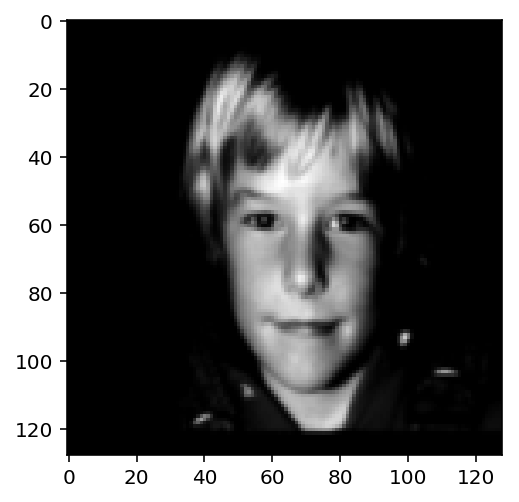

In [ ]:
# display the original face
def display_face(filename="1227"):
    path = '/content/drive/My Drive/data/mitfaces/raw/' + filename
    print(path)
    raw = np.fromfile(path, dtype='uint8', sep="")
    img = np.reshape(raw, (128, 128))
    plt.imshow(img, cmap="gray")

display_face()

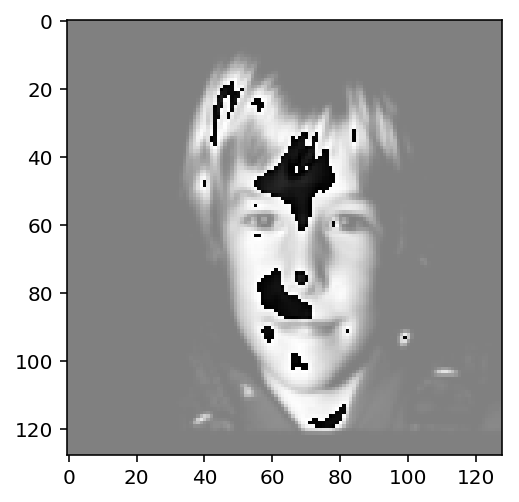

In [ ]:
#【CAUTION】【CAUTION】【CAUTION】
# if dtype="int8", grayscale will not be displayed properly
# this is an example of imporper reading of unsigned integer files
path = '/content/drive/My Drive/data/mitfaces/raw/1227'
raw = np.fromfile(path, dtype='int8', sep="")
img = np.reshape(raw, (128, 128))
plt.imshow(img, cmap="gray");

You can now find the mean face and 99 eigenfaces in the Matlab MAT-file ev.mat.    
The list of images used for training the eigenspace is in train_list.   

```
load ev.mat
load faceR
v = faceR(5, 2:100)';
i = eigenfaces'*v + mean_face';
imagesc(reshape(i, 128, 128)'); colormap(gray(256));
```

In [ ]:
'''
Two of the files, faceR and faceS, contain 99 coefficients for each of 2000 faces.
faceR should be used as training data; faceS for testing. Each row contains 100 elements.
The first element of each row contains a face number (running from 1223 to 5223);
the remaining 99 are coefficients measuring how much that face projects onto the corresponding eigenvector.
'''
path = "/content/drive/My Drive/data/mitfaces/faces/faceR"
with open(path) as f:
    faceR = f.read().splitlines()

arr = []
for str in faceR:
    row = str.strip().split(' ')
    arr.append(row)

df_faceR = pd.DataFrame(arr).set_index(0)
del df_faceR.index.name
df_faceR = df_faceR.iloc[:,:99]
df_faceR = df_faceR.replace(' ', '')
for col in df_faceR.columns:
    df_faceR[col] = pd.to_numeric(df_faceR[col])
    df_faceR = df_faceR.replace(np.nan, 0)
print('number of nan:', df_faceR.isnull().sum().sum())
print(df_faceR.shape)
df_faceR.head(2)

number of nan: 0
(2000, 99)


1           2           3   ...          97         98         99
1223 -1779.619019  2107.30127  807.759949  ...  144.583420 -86.194237  12.877232
1224 -2719.973389  2978.84375  -12.276579  ...  -46.186413  -4.687377 -42.803467

[2 rows x 99 columns]

In [ ]:
# import matlab file
from scipy.io import loadmat
path = "/content/drive/My Drive/data/mitfaces/faces/ev.mat"
dict_ev = loadmat(path)
dict_ev

{'eigenfaces': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'ev100': array([[0., 0., 0., ..., 0., 0., 0.]]),
 'mean_face': array([[0., 0., 0., ..., 0., 0., 0.]])}

In [ ]:
print('99 eigenfaces:', dict_ev['eigenfaces'].shape)
print('ev100?:', dict_ev['ev100'].shape)
print('mean face:', dict_ev['mean_face'].shape)

99 eigenfaces: (99, 16384)
ev100?: (1, 16384)
mean face: (1, 16384)


In [ ]:
# get list of faces that were used for training
path = "/content/drive/My Drive/data/mitfaces/faces/train_list"
with open(path) as f:
    train_list = f.read().splitlines()
print('train list length:', len(train_list))
print(train_list)

train list length: 101
['1227', '1234', '1262', '1266', '1290', '1313', '1353', '1400', '1414', '1451', '1456', '1494', '1513', '1599', '1600', '1601', '1616', '1657', '1671', '1681', '1727', '1762', '1772', '1802', '1805', '1861', '1872', '1900', '1911', '1913', '1927', '1945', '1986', '2005', '2013', '2024', '2029', '2063', '2065', '2074', '2090', '2095', '2104', '2117', '2132', '2158', '2181', '2185', '2203', '2225', '2229', '2251', '2263', '2321', '2322', '2336', '2349', '2370', '2393', '2425', '2449', '2451', '2465', '2466', '2474', '2475', '2479', '2494', '2495', '2505', '2524', '2526', '2539', '2550', '2618', '2661', '2680', '2685', '2725', '2735', '2746', '2770', '2776', '2781', '2807', '2834', '2853', '2899', '2935', '2937', '2955', '2957', '2983', '2996', '3022', '3039', '3057', '3116', '3133', '3155', '3178']


### Read file - Original faces

https://docs.scipy.org/doc/numpy/user/basics.types.html  
```
Numpy type	C type	Description
np.int8	int8_t	Byte (-128 to 127)
np.int16	int16_t	Integer (-32768 to 32767)
np.int32	int32_t	Integer (-2147483648 to 2147483647)
np.int64	int64_t	Integer (-9223372036854775808 to 9223372036854775807)
np.uint8	uint8_t	Unsigned integer (0 to 255)
```

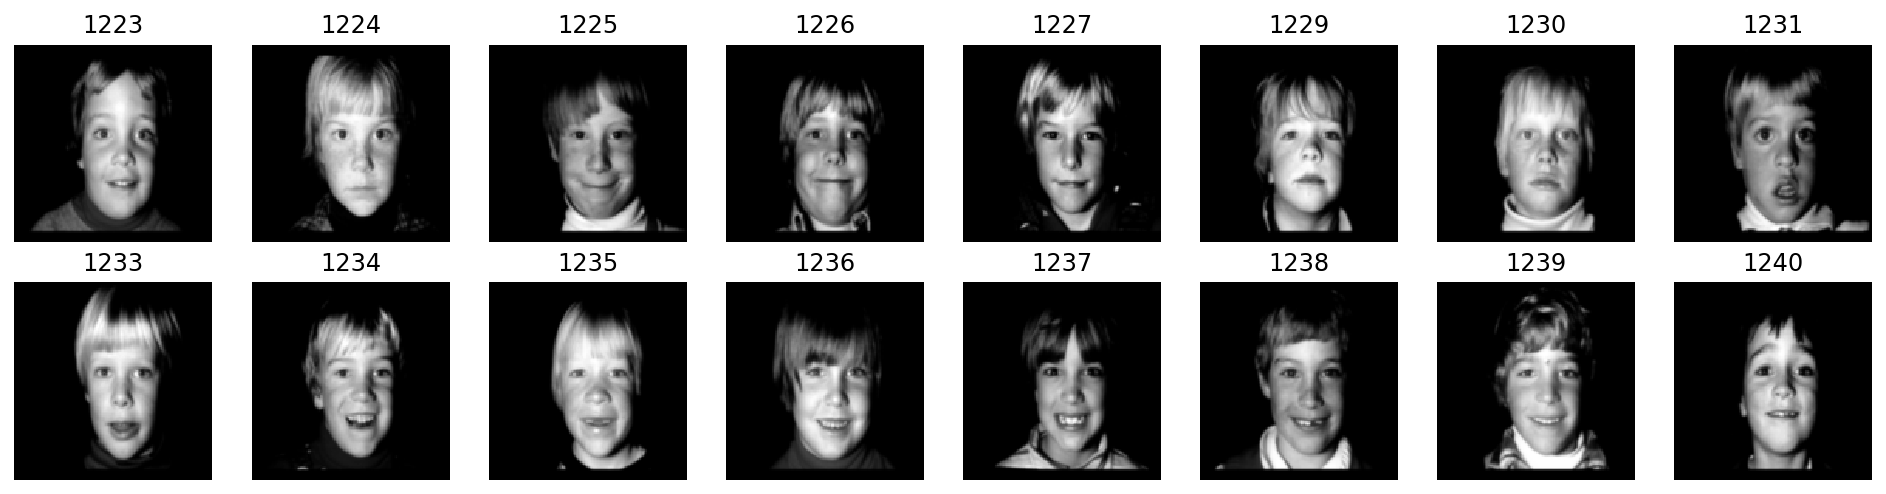

In [ ]:
fig, axes = plt.subplots(2,8, figsize=(17,4))
count = 0
for i in range(50):
    filename = df_faceR.index[i]
    path = '/content/drive/My Drive/data/mitfaces/raw/' + filename
    try:
        #【CAUTION】if dtype="int8", grapscale will not be displayed properly
        raw = np.fromfile(path, dtype='uint8', sep="")
    except FileNotFoundError:
        continue
    img = np.reshape(raw, (128, 128))
    ax = axes.flat[count]
    ax.imshow(img, cmap="gray")
    ax.set_title(filename)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.axis('off')
    count += 1
    if count >= 16:
        break

fig.subplots_adjust(hspace=0.2, wspace=0);

### Read file - Mean face

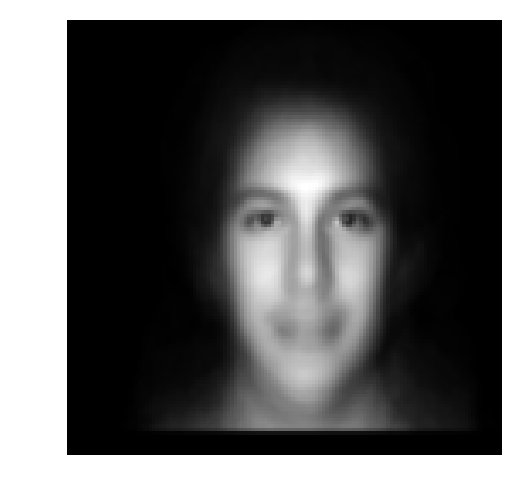

In [ ]:
# mean face
raw_mean = dict_ev['mean_face']
img = np.reshape(raw_mean, (128, 128))
plt.imshow(img, cmap="gray")
plt.axis('off');

### Read file - Eigenfaces

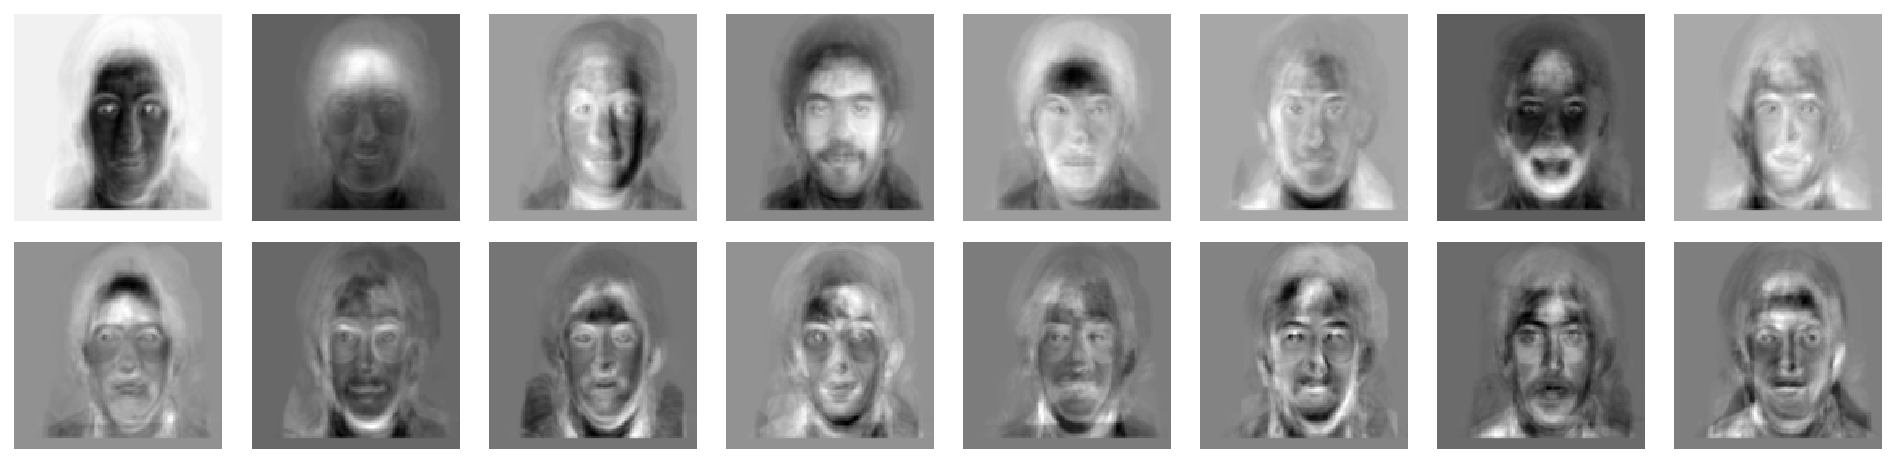

In [ ]:
# 99 eigenfaces
fig, axes = plt.subplots(2,8, figsize=(17,4))
for i in range(16):
    raw = dict_ev['eigenfaces'][i]
    img = np.reshape(raw, (128, 128))
    axes.flat[i].imshow(img, cmap="gray")
    axes.flat[i].axis('off')
fig.subplots_adjust(hspace=0.1, wspace=0);

### Reconstruct faces

In [ ]:
# faceR (train) and faceS (test), contain 99 coefficients for 2000 faces
print(df_faceR.loc['1227'].values.shape)
print(dict_ev['eigenfaces'].T.shape)
print(dict_ev['mean_face'].T.shape)

(99,)
(16384, 99)
(16384, 1)


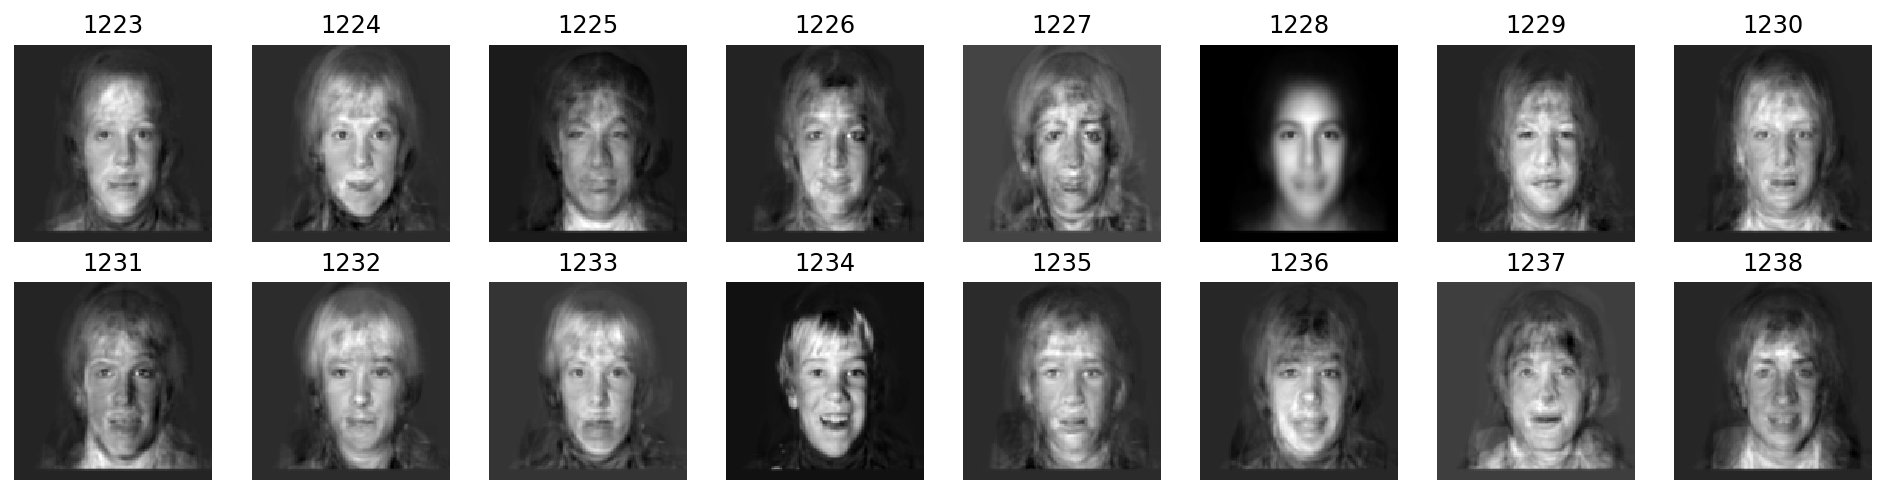

In [ ]:
# reconstruct the faces
# i = eigenfaces' * v + mean_face'
fig, axes = plt.subplots(2,8, figsize=(17,4))
for i in range(16):
    raw = np.matmul(df_faceR.iloc[i,:].values, dict_ev['eigenfaces']) \
        + dict_ev['mean_face']
    img = np.reshape(raw, (128, 128))
    ax = axes.flat[i]
    ax.imshow(img, cmap="gray")
    ax.set_title(df_faceR.index[i])
    ax.axis('off')
fig.subplots_adjust(hspace=0.2, wspace=0);

#【CAUTION】1228 is the mean face... i have no idea why it is here.

### Compare original and reconstructed faces

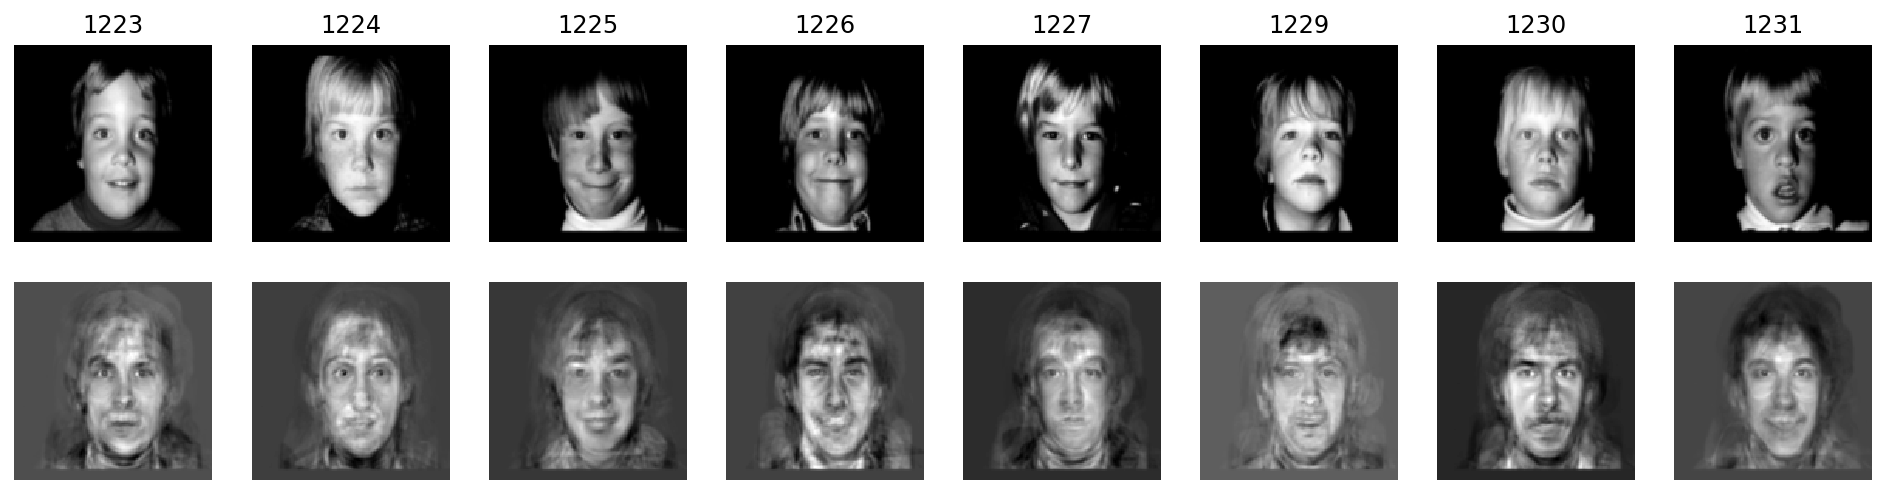

In [ ]:
# compare original and reconstructed faces
fig, axes = plt.subplots(2,8, figsize=(17,4))
count = 0
for i in range(50):
    filename = df_faceR.index[i]
    path = '/content/drive/My Drive/data/mitfaces/raw/' + filename
    try:
        raw = np.fromfile(path, dtype='uint8', sep="")
    except FileNotFoundError:
        continue
    img = np.reshape(raw, (128, 128))
    ax = axes.flat[count]
    ax.imshow(img, cmap="gray")
    ax.set_title(filename)
    ax.axis('off')

    raw = np.matmul(df_faceR.loc[filename].values,
                    dict_ev['eigenfaces']) \
          + dict_ev['mean_face']
    img = np.reshape(raw, (128, 128))
    ax = axes.flat[count+8]
    ax.imshow(img, cmap="gray")
    ax.axis('off')

    count += 1
    if count >= 8:
        break

fig.subplots_adjust(hspace=0.2, wspace=0);

# 101 training faces

### Reproduce mean face

In [ ]:
# read all images in train list
train = []
for filename in train_list:
    path = '/content/drive/My Drive/data/mitfaces/raw/' + filename
    try:
        raw = np.fromfile(path, dtype='uint8', sep="")
        train.append(raw.tolist())
    except FileNotFoundError:
        continue
df_train = pd.DataFrame(train)
del train

In [ ]:
print(df_train.shape)
df_train.iloc[:2,:20]

(101, 16384)


0   1   2   3   4   5   6   7   8   ...  11  12  13  14  15  16  17  18  19
0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   0   0
1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   0   0

[2 rows x 20 columns]

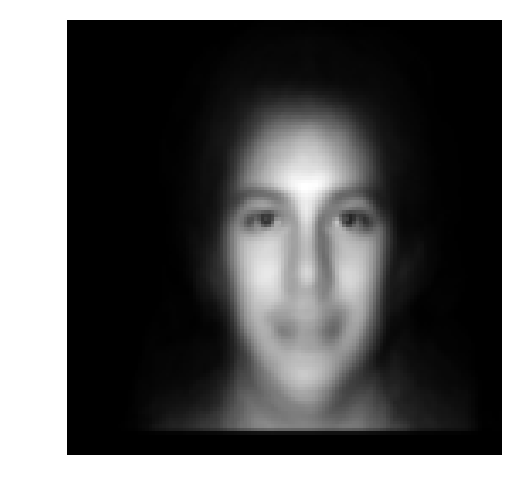

In [ ]:
mean_face = df_train.mean().to_list()
img = np.reshape(mean_face, (128, 128))
plt.imshow(img, cmap="gray")
plt.axis('off');

### Reproduce eigenfaces

https://sandipanweb.wordpress.com/2018/01/06/eigenfaces-and-a-simple-face-detector-with-pca-svd-in-python/    
<img src="https://sandipanweb.files.wordpress.com/2017/12/f1.png" width=800>    

**sklearn.decomposition.PCA**   
https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html   
**sklearn.decomposition.TruncatedSVD**     
https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html    
https://en.wikipedia.org/wiki/Singular_value_decomposition   

In [ ]:
# center the data first
df_centered = df_train - mean_face
df_centered.shape

(101, 16384)

In [ ]:
%%time
# svd = TruncatedSVD(n_components=99, n_iter=7, random_state=42)
svd = TruncatedSVD(n_components=99)
arr_svd = svd.fit_transform(df_centered)
print('svd.explained_variance_ratio_.sum():', svd.explained_variance_ratio_.sum())

print(arr_svd.T.shape, df_train.shape)
eigenfaces_svd = np.matmul(arr_svd.T, df_train.values)
print(svd_eigenfaces.shape)

svd.explained_variance_ratio_.sum(): 0.9997531249249254
(99, 101) (101, 16384)
(99, 16384)
CPU times: user 1.18 s, sys: 517 ms, total: 1.69 s
Wall time: 873 ms


In [ ]:
%%time

# pca = PCA(n_components=99)
pca = PCA(n_components=99)
arr_pca = pca.fit_transform(df_train)
print('pca.explained_variance_ratio_.sum():', pipeline['pca'].explained_variance_ratio_.sum())
eigenfaces_pca = np.matmul(arr_pca.T, df_train.values)

pca = PCA(n_components=99, whiten=True)
arr_pca_whiten = pca.fit_transform(df_train)
eigenfaces_pca_whiten = np.matmul(arr_pca_whiten.T, df_train.values)

pipeline = Pipeline([('scaling', StandardScaler()),
                     ('pca', PCA(n_components=99, whiten=True))])
arr_pca_standardized = pipeline.fit_transform(df_train)
eigenfaces_pca_standardized = np.matmul(arr_pca_standardized.T, df_train.values)

pca.explained_variance_ratio_.sum(): 0.9998099437596724
CPU times: user 1.02 s, sys: 237 ms, total: 1.25 s
Wall time: 950 ms


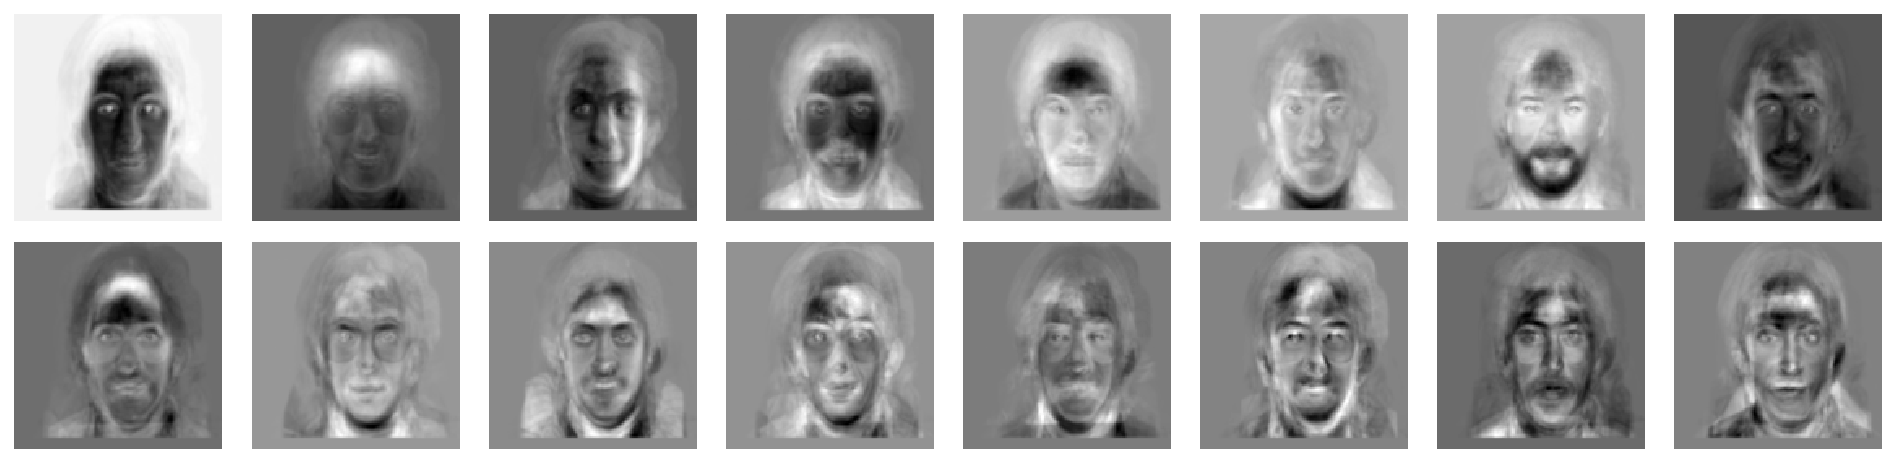

In [ ]:
# 99 eigenfaces - first PCAs
fig, axes = plt.subplots(2,8, figsize=(17,4))
for i in range(16):
    raw = eigenfaces_pca[i]
    img = np.reshape(raw, (128, 128))
    axes.flat[i].imshow(img, cmap="gray")
    axes.flat[i].axis('off')
fig.subplots_adjust(hspace=0.1, wspace=0);

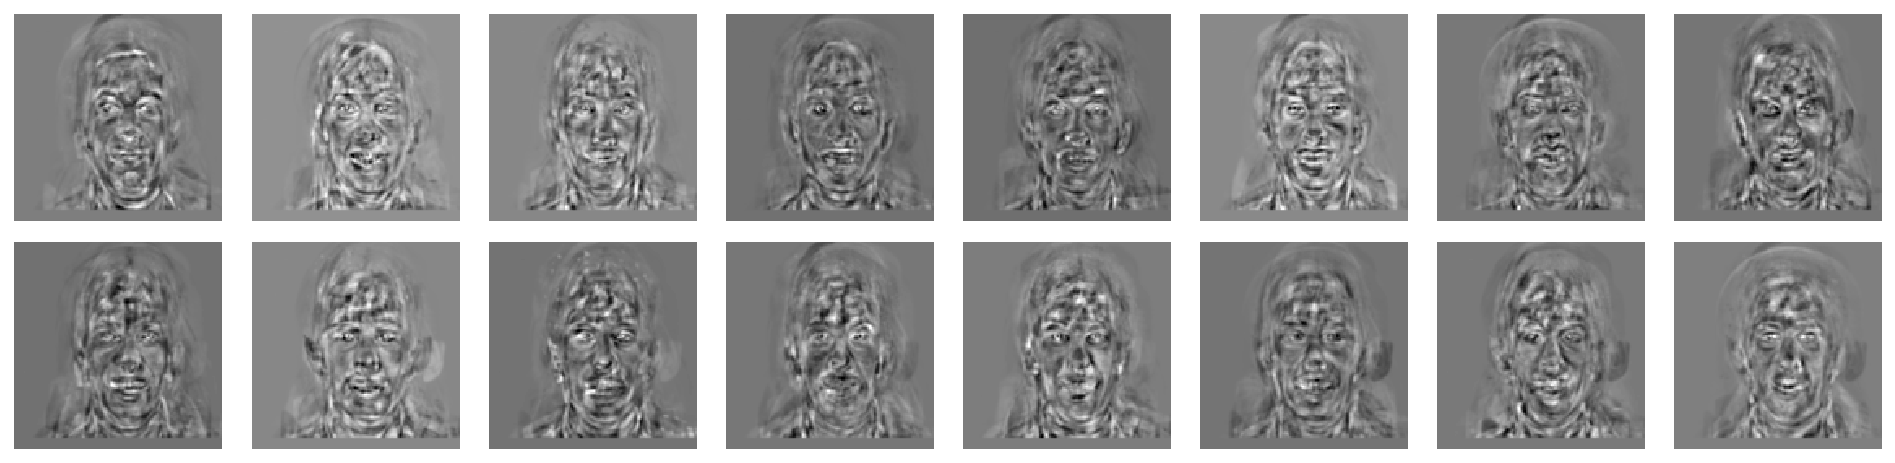

In [ ]:
# 99 eigenfaces - last PCAs
fig, axes = plt.subplots(2,8, figsize=(17,4))
for i in range(16):
    raw = eigenfaces_pca[-i-1]
    img = np.reshape(raw, (128, 128))
    axes.flat[i].imshow(img, cmap="gray")
    axes.flat[i].axis('off')
fig.subplots_adjust(hspace=0.1, wspace=0);

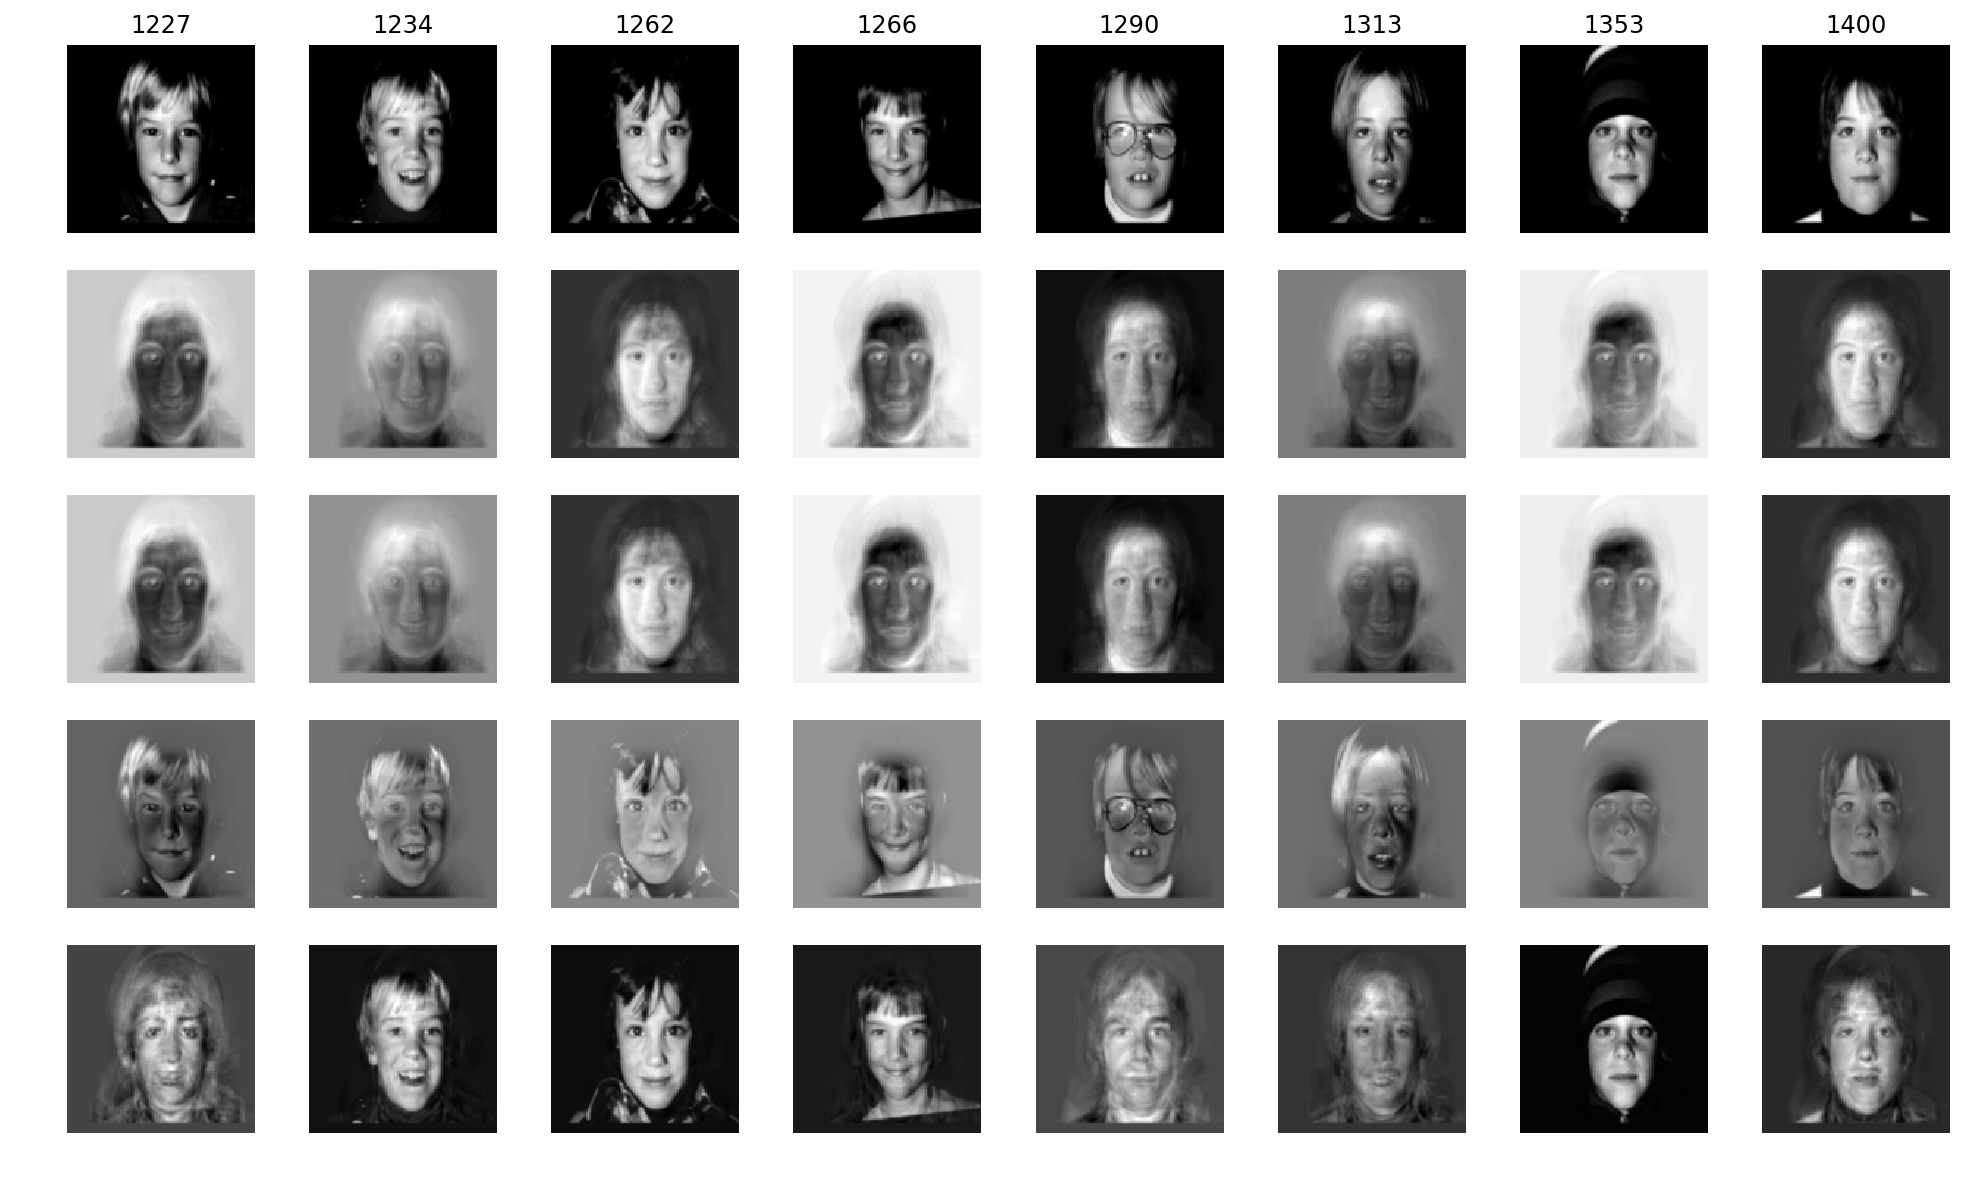

In [ ]:
# compare original and reconstructed faces
fig, axes = plt.subplots(5,8, figsize=(17,10), sharey=True)
count = 0
for i in range(50):
    filename = train_list[i]
    path = '/content/drive/My Drive/data/mitfaces/raw/' + filename
    try:
        raw = np.fromfile(path, dtype='uint8', sep="")
    except FileNotFoundError:
        continue
    img = np.reshape(raw, (128, 128))
    ax = axes.flat[count]
    ax.imshow(img, cmap="gray")
    ax.set_title(filename)
    ax.axis('off')

##【Caution】skelearn.decomposition.TruncatedSVD or PCA
## could generate very different results given different parameters

    raw = np.matmul(arr_svd[i], eigenfaces_svd) + meanface
    img = np.reshape(raw, (128, 128))
    ax = axes.flat[count+8]
    ax.imshow(img, cmap="gray")
    ax.axis('off')

    raw = np.matmul(arr_pca[i], eigenfaces_pca) + meanface
    img = np.reshape(raw, (128, 128))
    ax = axes.flat[count+16]
    ax.imshow(img, cmap="gray")
    ax.axis('off')

    raw = np.matmul(arr_pca_whiten[i], eigenfaces_pca_whiten) + meanface
    img = np.reshape(raw, (128, 128))
    ax = axes.flat[count+24]
    ax.imshow(img, cmap="gray")
    ax.axis('off')

    raw = np.matmul(df_faceR.loc[filename].values, dict_ev['eigenfaces']) + dict_ev['mean_face']
    img = np.reshape(raw, (128, 128))
    ax = axes.flat[count+32]
    ax.imshow(img, cmap="gray")
    ax.axis('off')

    count += 1
    if count >= 8:
        break

fig.subplots_adjust(hspace=0.2, wspace=0.2);

### PCA number of components <= min(number of rows, number of columns)

<img src="https://sandipanweb.files.wordpress.com/2018/01/f2.png" width=400>

# Same training data, different Eigenfaces

<img src='https://github.com/Nov05/pictures/blob/master/gifs/2019-10-18%20eigenfaces.gif?raw=true'>